In [1]:
## first let's get the data ready
import os
import time
import pandas as pd
import pickle

import torch
from torch.utils.data import Dataset, DataLoader

import pyro
from pyro.nn import PyroModule
import pyro.distributions as dist
import pyro.distributions.constraints as constraints



import sys
sys.path.insert(0, '/home/djl34/lab_pd/kl/git/KL/scripts')
import raklette
from run_raklette import run_raklette
from run_raklette import run_raklette_cov
from run_raklette import TSVDataset

## Useful transformations
####################################################
pad = torch.nn.ConstantPad1d((1,0), 0.)           # Add a 0 to a tensor
softmax = torch.nn.Softmax(-1)                    # softmax transform along the last dimension
relu = torch.nn.ReLU()                            # map everything < 0 -> 0
order_trans = dist.transforms.OrderedTransform()  # y_0=x_0; y_i=y_0+sum_j=1^i exp(x_j) [not really used anymore, weird properties]
## Transformations of the SFS
####################################################
def multinomial_trans(sfs_probs, offset=None):
    sfs_probs = np.array(sfs_probs)
    P_0 = sfs_probs[...,0]
    if offset:
        betas = np.log(sfs_probs[...,1:]) - np.log(P_0[...,None]) - offset
    else:
        betas = np.log(sfs_probs[...,1:]) - np.log(P_0[...,None])
    return betas

def multinomial_trans_torch(sfs_probs):
    P_0 = sfs_probs[...,0]
    return torch.log(sfs_probs[...,1:]) - torch.log(P_0[...,None])

def KL_fw(neut_probs, sel_probs):
    return np.sum(neut_probs * (np.log(neut_probs) - np.log(sel_probs)), axis=-1)

def KL_rv(neut_probs, sel_probs):
    return np.sum(sel_probs * (np.log(sel_probs) - np.log(neut_probs)), axis=-1)

In [2]:
KL_data_dir = "/home/djl34/lab_pd/kl/data"
pd_data_dir = "/home/djl34/lab_pd/data"
scratch_dir = "/n/scratch3/users/d/djl34"

variants = os.path.join(scratch_dir, "kl_input/" + "{header}/chunk_{chunksize}_0.tsv")
length_file = os.path.join(scratch_dir, "kl_input/"+ "{header}_length.tsv")
neutral_sfs = os.path.join(KL_data_dir, "whole_genome/allele_freq/adaptive_bins/all.tsv")

replace = "single_feature/zoonomia/22"

variants = variants.replace("{header}", replace)
variants = variants.replace("{chunksize}", "1000000")
length_file = length_file.replace("{header}", replace)


In [3]:
variants

'/n/scratch3/users/d/djl34/kl_input/single_feature/zoonomia/22/chunk_1000000_0.tsv'

In [4]:
input_filename = variants
# output_filename = output[0]
neutral_sfs_filename = neutral_sfs
input_length_file = length_file

chunksize = int(1000000)
num_epochs = int(1)
cov_prior = float(0.1)
learning_rate = float(0.01)
gamma = float(0.5)

In [5]:
input_directory = "/".join(input_filename.split("/")[:-1]) + "/"

df = pd.read_csv(input_length_file, sep = "\t", header = None)
nb_samples = df[0][0]
nb_features = df[0][1] - 2

print("number of samples: " + str(nb_samples), flush = True)

if nb_samples == 0:
    f = open(output_filename, "w")
    f.write("no sample")
    f.close()
else:        
    with open(input_filename) as f:
        first_line = f.readline()
    header = first_line.split("\t")

    if chunksize == 0:
        print("number of chunks: " + str(0), flush = True)
    else:
        print("number of chunks: " + str(nb_samples/chunksize), flush = True)

    dataset = TSVDataset(input_directory, chunksize=chunksize, nb_samples = nb_samples, header_all = header, features = header)
    loader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False)

#     #lets run raklette
#     run_raklette.run_raklette_cov_new(loader, nb_features, num_epochs, neutral_sfs_filename, output_filename, 
#                  float(learning_rate), float(gamma), 
#                      cov_sigma_prior = torch.tensor(cov_prior, dtype=torch.float32))

number of samples: 48672365
number of chunks: 48.672365


## set up two different raKLettes: original one with covariates, and another one with neural net

In [6]:
class raklette_cov():
    def __init__(self, neut_sfs_full, n_bins, n_covs, cov_sigma_prior = torch.tensor(0.1, dtype=torch.float32),
                 ref_mu_ii=-1):

#         mu = torch.unique(mu_vals)             # set of all possible mutation rates
#         n_mu = len(mu)                         # number of unique mutation rates

        beta_neut_full = multinomial_trans_torch(neut_sfs_full) #neut_sfs_full is the neutral sfs
        self.beta_neut_full = beta_neut_full

        beta_neut = beta_neut_full[ref_mu_ii,:]
        self.beta_neut = beta_neut

        self.n_bins = n_bins
        self.n_covs = n_covs

        self.cov_sigma_prior = cov_sigma_prior

    def model(self, mu_vals, covariates, sample_sfs=None):
        '''
        Run the model for a given dataset, defined by mutation rates, gene_ids, and other covariates

        Parameters
        ----------
        mu_vals :
            The mutation rate for each site being analyzed by the model as a 1D array, proportional to per-generation ideally
        covariates :
            Matrix of covariates
        sample_sfs :
            The observed binned SFS data we are fitting the model to

        '''
        n_sites = len(mu_vals)
            
        #beta for covariates
        beta_cov = pyro.sample("beta_cov", dist.HalfCauchy(self.cov_sigma_prior).expand([self.n_covs, self.n_bins]).to_event(1))    
            
        beta_cov_trans = torch.cumsum(beta_cov, dim=-1)

        # calculate the multinomial coefficients for each mutation rate
        mn_sfs = self.beta_neut_full[None,...]
        
        # convert to probabilities per-site and adjust for covariates
        sfs = softmax(pad(mn_sfs[..., mu_vals, :] - torch.matmul(covariates, beta_cov_trans)))
        
        with pyro.plate("sites", n_sites):
            pyro.sample("obs", dist.Categorical(sfs), obs=sample_sfs)

In [7]:
class Linear_first(PyroModule):
    def __init__(self, in_size, out_size, cov_sigma_prior):
        super().__init__()
        self.weight = PyroSample(dist.HalfCauchy(cov_sigma_prior).expand([in_size, out_size]).to_event(1))
        
    def forward(self, input_):
        return input_ @ self.weight
    

class softmax_sfs(PyroModule):
    def __init__(self, beta_neut_full):
        super().__init__()
        # calculate the multinomial coefficients for each mutation rate
        self.mn_sfs = beta_neut_full[None,...]

    def forward(self, mu_vals, input_):
        
        #I want to check if the cumulative sum is still correct
        input_cumsum = torch.cumsum(self.input_, dim=-1)
        # convert to probabilities per-site and adjust for covariates
        sfs = softmax(pad(self.mn_sfs[..., mu_vals, :] - input_cumsum))
        
        return sfs

class raklette_neuralnet():
    def __init__(self, neut_sfs_full, n_bins, n_covs, cov_sigma_prior = torch.tensor(0.1, dtype=torch.float32),
                 ref_mu_ii=-1):

        beta_neut_full = multinomial_trans_torch(neut_sfs_full) #neut_sfs_full is the neutral sfs
        
        self.fc1 = nn.Linear_first(n_covs, n_bins, cov_sigma_prior)  # set up first FC layer
        self.softmax_sfs = softmax_sfs(beta_neut_full)
        

    def model(self, mu_vals, covariates, sample_sfs=None):
        '''
        Run the model for a given dataset, defined by mutation rates, gene_ids, and other covariates

        Parameters
        ----------
        mu_vals :
            The mutation rate for each site being analyzed by the model as a 1D array, proportional to per-generation ideally
        covariates :
            Matrix of covariates
        sample_sfs :
            The observed binned SFS data we are fitting the model to
        '''
        n_sites = len(mu_vals)
            
        ly1 = self.fc1(covariates)
        sfs = self.softmax_sfs(mu_vals, ly1)
        
        with pyro.plate("sites", n_sites):
            pyro.sample("obs", dist.Categorical(sfs), obs=sample_sfs)

## let's now try running the inference step to compare the two different models

In [8]:
def run_raklette(inference, loader, n_covs, num_epochs, neutral_sfs_filename, output_filename, lr, gamma, cov_sigma_prior = torch.tensor(0.1, dtype=torch.float32), mu_col = 0, bin_col = 1, cov_col = 2, print_loss = True):
    #lr is initial learning rate

    print("running raklette", flush=True)

    # read neutral sfs
    sfs = pd.read_csv(neutral_sfs_filename, sep = "\t")
    bin_columns = []
    for i in range(len(sfs.columns) - 2):
        bin_columns.append(str(float(i)))
    neutral_sfs = torch.tensor(sfs[bin_columns].values)
    mu_ref = torch.tensor(sfs["mu"].values)
    n_bins = len(neutral_sfs[1]) - 1
    print("number of bins: " + str(n_bins), flush = True)

    KL = inference(neutral_sfs, n_bins, n_covs, cov_sigma_prior = cov_sigma_prior)
                
    model = KL.model
    guide = pyro.infer.autoguide.AutoNormal(model)

    #run inference
    pyro.clear_param_store()
    
    num_steps = num_epochs * len(loader)
    lrd = gamma ** (1 / num_steps)
    
    # run SVI
    optimizer = pyro.optim.ClippedAdam({"lr":lr, 'lrd': lrd})
#     optimizer = pyro.optim.Adam({"lr":lr})
    elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
    svi = pyro.infer.SVI(model, guide, optimizer, elbo)
    losses = []
    
    start = time.time()
    divide_by = 1

    for epoch in range(num_epochs):
        if print_loss:
            print("epoch: " + str(epoch), flush = True)

        # Take a gradient step for each mini-batch in the dataset
        for batch_idx, data in enumerate(loader):
            if batch_idx % divide_by == 0:
                if print_loss:
                    print("\t batch: " + str(batch_idx), flush = True)
                end = time.time()
                if print_loss:
                    print("\t\t time from last batch: " + str(end - start), flush = True)
                start = time.time()
                
            ## changing values into tensor format

            mu_vals = data[:,:,mu_col].reshape(-1)
            mu_vals = mu_vals.type(torch.LongTensor)

            freq_bins = data[:,:,bin_col].reshape(-1)

            if n_covs == 1:
                covariate_vals = torch.squeeze(data[:,:,cov_col:]).unsqueeze(-1)
            else:
                covariate_vals = torch.squeeze(data[:,:,cov_col:])
                
            covariate_vals = covariate_vals.type(torch.FloatTensor)

            if batch_idx % divide_by == 0:
                end = time.time()
                if print_loss:
                    print("\t\t time to get tensors: " + str(end - start), flush = True)
                start = time.time()
    
            loss = svi.step(mu_vals, covariate_vals, freq_bins)
        
            if batch_idx % divide_by == 0:
                end = time.time()
                if print_loss:
                    print("\t\t time to get run svi step: " + str(end - start), flush = True)
                start = time.time()

            losses.append(loss/data.shape[1])
            
            if batch_idx % divide_by == 0:
                end = time.time()
                if print_loss:
                    print("\t\t time to append loss: " + str(end - start), flush = True)
                start = time.time()

            if batch_idx % divide_by == 0:
                if print_loss:
                    print("\t\t loss: " + str(loss/data.shape[1]), flush=True)

    model_filename = ".".join(output_filename.split(".")[:-1]) + ".model"
    param_filename = ".".join(output_filename.split(".")[:-1]) + ".params"
    
    output_dict = {}
    output_dict['KL']=KL
    output_dict['model']=model
    output_dict['guide']=guide
    
    with open(model_filename, 'wb') as handle:
        pickle.dump(output_dict, handle)
        
    pyro.get_param_store().save(param_filename)

    print("Finished training!", flush=True)

    ##############################post inference##############################
    
    result = raklette.post_analysis_cov(neutral_sfs, mu_ref, n_bins, n_covs, losses, cov_sigma_prior = cov_sigma_prior)
    
    print("dumping file to output")
    with open(output_filename, 'wb') as f:
        pickle.dump(result, f)

In [9]:
#lets run raklette
output_filename = os.path.join(KL_data_dir, "raklette_output/"+ "{header}_chunk_{chunksize}_covonly_lr_{learning_rate}_gamma_{gamma}_epoch_{epoch}_covprior_{cov_prior}")

replace = "single_feature/zoonomia/22"

output_filename = output_filename.replace("{header}", replace)
output_filename = output_filename.replace("{chunksize}", str(chunksize))
output_filename = output_filename.replace("{learning_rate}", str(learning_rate))
output_filename = output_filename.replace("{gamma}", str(gamma))
output_filename = output_filename.replace("{epoch}", str(num_epochs))
output_filename_header = output_filename.replace("{cov_prior}", str(cov_prior))

running raklette
number of bins: 9
epoch: 0
	 batch: 0
		 time from last batch: 0.7647233009338379
		 time to get tensors: 0.03808283805847168
		 time to get run svi step: 4.703955411911011
		 time to append loss: 1.7642974853515625e-05
		 loss: 0.3025532938345183
	 batch: 1
		 time from last batch: 0.00863337516784668
		 time to get tensors: 0.026253938674926758
		 time to get run svi step: 2.5542054176330566
		 time to append loss: 9.775161743164062e-06
		 loss: 0.30296737639273197
	 batch: 2
		 time from last batch: 0.014069557189941406
		 time to get tensors: 0.05148029327392578
		 time to get run svi step: 2.6949455738067627
		 time to append loss: 1.0251998901367188e-05
		 loss: 0.30302456401839073
	 batch: 3
		 time from last batch: 0.008729934692382812
		 time to get tensors: 0.057718515396118164
		 time to get run svi step: 2.763763427734375
		 time to append loss: 1.239776611328125e-05
		 loss: 0.302013021750037
	 batch: 4
		 time from last batch: 0.009314775466918945
		 time

		 time to get run svi step: 2.3508055210113525
		 time to append loss: 8.821487426757812e-06
		 loss: 0.30197145782710577
	 batch: 37
		 time from last batch: 0.028268814086914062
		 time to get tensors: 0.03626728057861328
		 time to get run svi step: 2.342942476272583
		 time to append loss: 9.059906005859375e-06
		 loss: 0.3013490043426256
	 batch: 38
		 time from last batch: 0.019498109817504883
		 time to get tensors: 0.034081459045410156
		 time to get run svi step: 2.3295979499816895
		 time to append loss: 8.821487426757812e-06
		 loss: 0.3020467535779035
	 batch: 39
		 time from last batch: 0.01968216896057129
		 time to get tensors: 0.05185651779174805
		 time to get run svi step: 2.3642053604125977
		 time to append loss: 8.821487426757812e-06
		 loss: 0.3010324320700405
	 batch: 40
		 time from last batch: 0.019717693328857422
		 time to get tensors: 0.0512080192565918
		 time to get run svi step: 2.34259033203125
		 time to append loss: 1.0013580322265625e-05
		 loss: 0.3

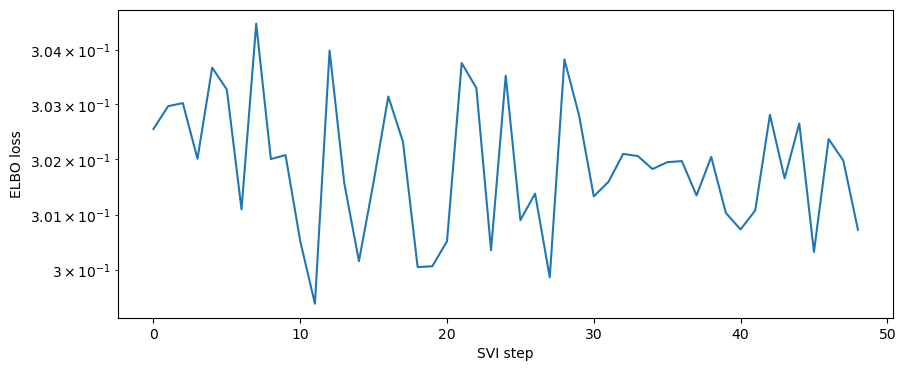

In [10]:
output_filename = output_filename + "_original.pkl"

run_raklette(raklette_cov, loader, nb_features, num_epochs, neutral_sfs_filename, output_filename, 
             float(learning_rate), float(gamma), 
                 cov_sigma_prior = torch.tensor(cov_prior, dtype=torch.float32))